# ***Importing libraries***

In [3]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


# ***Fetch Images count from Fodlers***

In [5]:
count = 0 
dirs = os.listdir('images/')
for dir in dirs:
    files = list(os.listdir('images/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' images')
    count = count + len(files)
print( 'Images Folder has '+ str(count) + ' images')

.ipynb_checkpoints Folder has 1 images
bougainvillea Folder has 61 images
daisy Folder has 96 images
frangipani Folder has 104 images
hibiscus Folder has 115 images
rose Folder has 84 images
sunflower Folder has 75 images
zinnia Folder has 118 images
Images Folder has 654 images


# ***Load Images into Arrays as Dataset***

In [9]:
base_dir = 'images/'
img_size = 180
batch = 32

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 653 files belonging to 7 classes.
Using 523 files for training.
Found 653 files belonging to 7 classes.
Using 130 files for validation.


In [13]:
flower_names = train_ds.class_names
flower_names

['bougainvillea',
 'daisy',
 'frangipani',
 'hibiscus',
 'rose',
 'sunflower',
 'zinnia']

In [15]:
import matplotlib.pyplot as plt

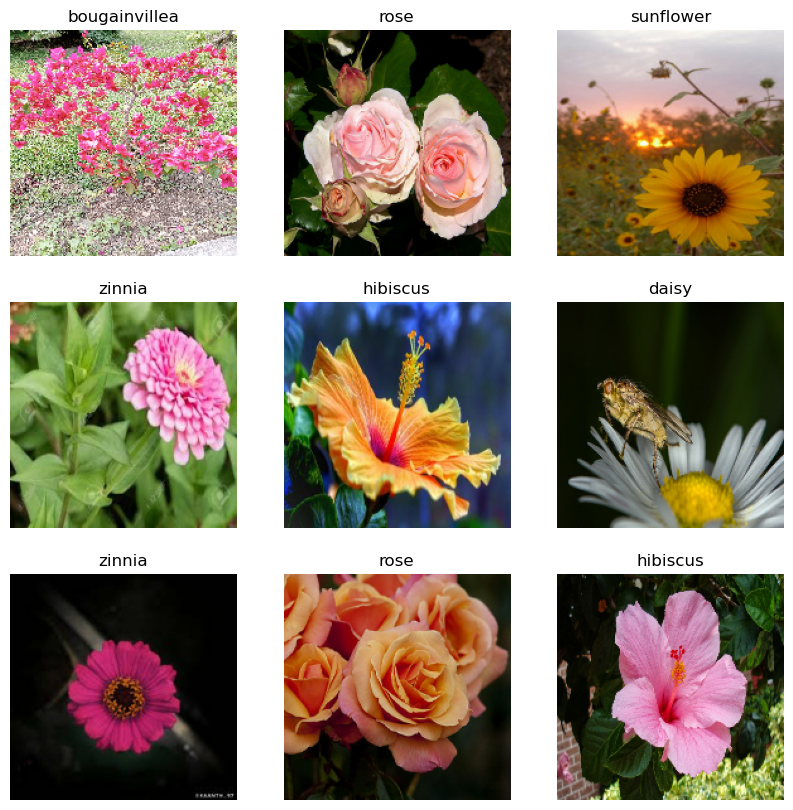

In [17]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [23]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# ***Data Augmentation***

In [25]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

C:\Users\Saurav\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


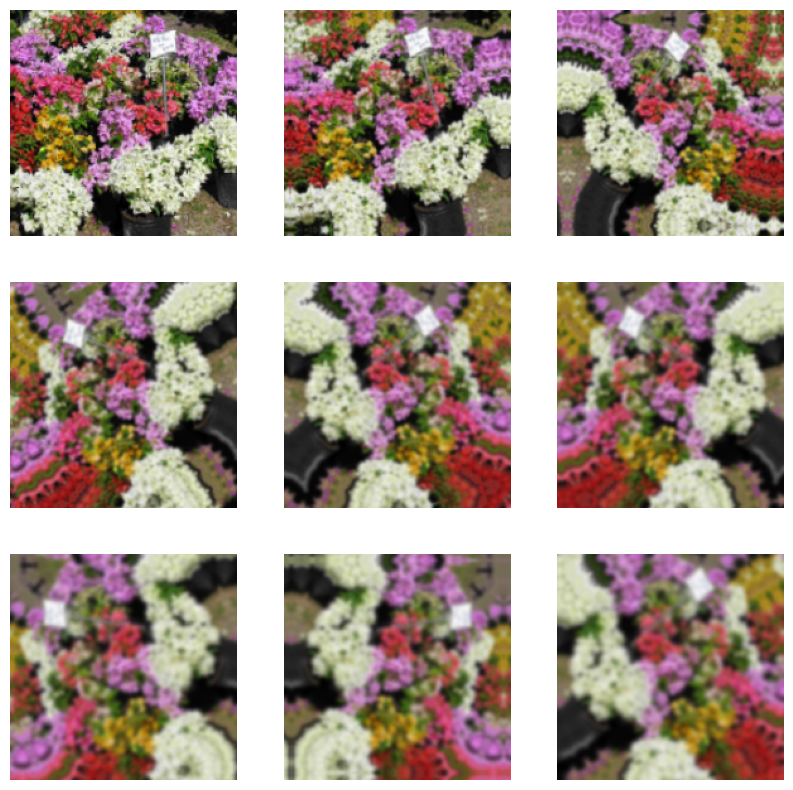

In [27]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

# ***Segmentation***

In [29]:
# Define paths
preprocessed_data_path = "./Images"
segmentation_output_path = "./segmented_data"

# Parameters
IMG_SIZE = (128, 128)  # Ensure consistent input size

# Create output directories for each class if they don't exist
if not os.path.exists(segmentation_output_path):
    os.makedirs(segmentation_output_path)

In [31]:
# Function for Canny Edge Detection
def edge_detection(image):
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    return edges

In [33]:
# Function for Region-Based Segmentation (using Thresholding + Morphological operations)
def region_segmentation(image):
    # Convert to grayscale if the image is in color
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding
    _, thresholded = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    
    # Morphological operations to enhance segmented regions
    kernel = np.ones((3, 3), np.uint8)
    # Morphological opening to remove small noise
    opened = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)
    # Dilation to make regions more distinct
    dilated = cv2.dilate(opened, kernel, iterations=1)
    return dilated

In [21]:
import cv2
from tqdm import tqdm
# Loop through each image in each class folder
for class_folder in os.listdir(preprocessed_data_path):
    class_path = os.path.join(preprocessed_data_path, class_folder)
    output_class_path = os.path.join(segmentation_output_path, class_folder)
    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    # Process each image in the class folder
    for image_name in tqdm(os.listdir(class_path), desc=f"Segmenting {class_folder}"):
        image_path = os.path.join(class_path, image_name)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {image_path}, failed to load.")
            continue

        # Apply Canny edge detection
        edges = edge_detection(image)
        edge_output_path = os.path.join(output_class_path, f"edges_{image_name}")
        cv2.imwrite(edge_output_path, edges)

        # Apply region-based segmentation
        segmented_regions = region_segmentation(image)
        region_output_path = os.path.join(output_class_path, f"region_{image_name}")
        cv2.imwrite(region_output_path, segmented_regions)

Segmenting .ipynb_checkpoints: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping ./Images\.ipynb_checkpoints\Flower_recog_Model-checkpoint.ipynb, failed to load.


Segmenting zinnia: 100%|██████████| 118/118 [00:02<00:00, 56.23it/s]


# ***Visualization of segmented images***

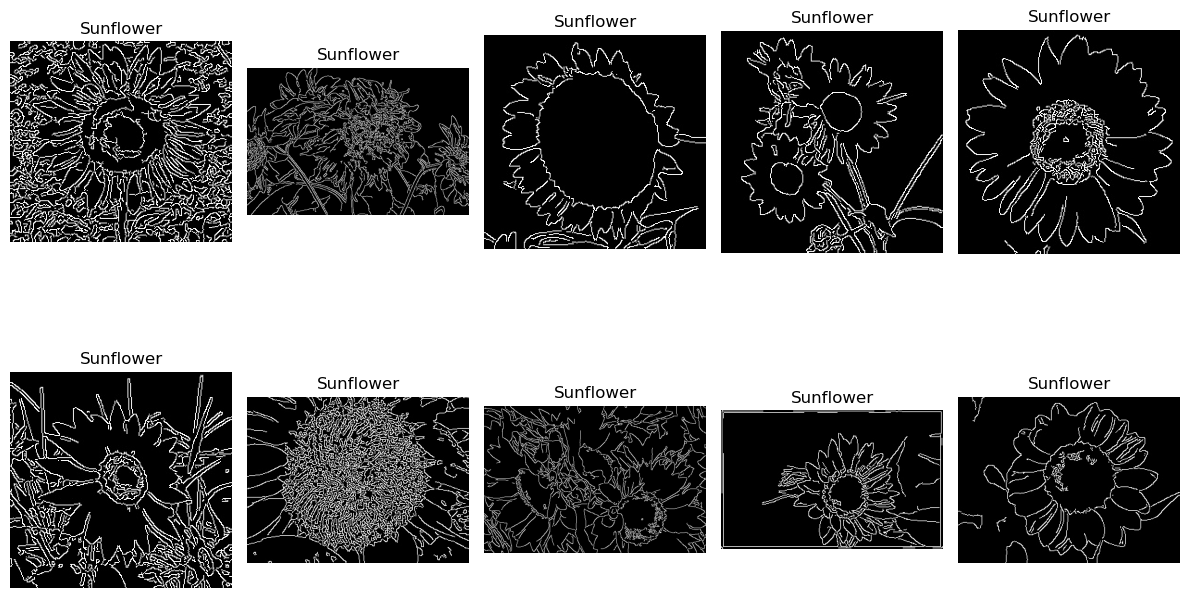

In [35]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the directory containing output images
output_directory = r"C:\Users\Saurav\Documents\ImageProcessingAssignment\segmented_data\sunflower"  # Replace with your directory

# List all image files in the directory
image_files = [f for f in os.listdir(output_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Plot images
plt.figure(figsize=(12, 8))  # Set figure size
for i, img_file in enumerate(image_files[:10]):  # Limit to first 10 images for visualization
    img_path = os.path.join(output_directory, img_file)
    
    # Read image using cv2
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read {img_path}. Skipping.")
        continue
    
    # Convert BGR to RGB for displaying with matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Add subplot
    plt.subplot(2, 5, i + 1)  # Create a grid with 2 rows and 5 columns
    plt.imshow(image)
    plt.title("Sunflower")  # Use filename as title
    plt.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


# ***Detection***

In [45]:
# Define paths
segmentation_data_path = "./segmented_data"
detection_output_path = "./detected_data"

# Parameters
IMG_SIZE = (128, 128)

# Create output directories for each class if they don't exist
if not os.path.exists(detection_output_path):
    os.makedirs(detection_output_path)

# ***Detection in images***

In [49]:
import cv2
# Function to perform Selective Search for region proposals
def selective_search(image):
    # Initialize Selective Search segmentation
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects
from tqdm import tqdm
# Function to detect objects using contours and draw bounding boxes
def contour_detection(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter small contours by area
            x, y, w, h = cv2.boundingRect(contour)
            boxes.append((x, y, w, h))
    return boxes

# Loop through each image in each class folder
for class_folder in os.listdir(segmentation_data_path):
    class_path = os.path.join(segmentation_data_path, class_folder)
    output_class_path = os.path.join(detection_output_path, class_folder)
    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    # Process each image in the class folder
    for image_name in tqdm(os.listdir(class_path), desc=f"Detecting in {class_folder}"):
        image_path = os.path.join(class_path, image_name)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {image_path}, failed to load.")
            continue

        # 1. Apply Selective Search to propose regions
        rects = selective_search(image)
        selective_search_image = image.copy()
        for (x, y, w, h) in rects[:100]:  # Limiting to first 100 regions for visibility
            cv2.rectangle(selective_search_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        selective_output_path = os.path.join(output_class_path, f"ss_{image_name}")
        cv2.imwrite(selective_output_path, selective_search_image)

        # 2. Apply Contour Detection for bounding boxes
        boxes = contour_detection(image)
        contour_image = image.copy()
        for (x, y, w, h) in boxes:
            cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        contour_output_path = os.path.join(output_class_path, f"contour_{image_name}")
        cv2.imwrite(contour_output_path, contour_image)

Detecting in .ipynb_checkpoints: 0it [00:00, ?it/s]
Detecting in bougainvillea:   1%|▍                                                   | 1/122 [00:48<1:38:44, 48.96s/it]


KeyboardInterrupt: 

# ***Detection is previously done already but by mistake i have runned it..***

# ***visualizing for detection data***

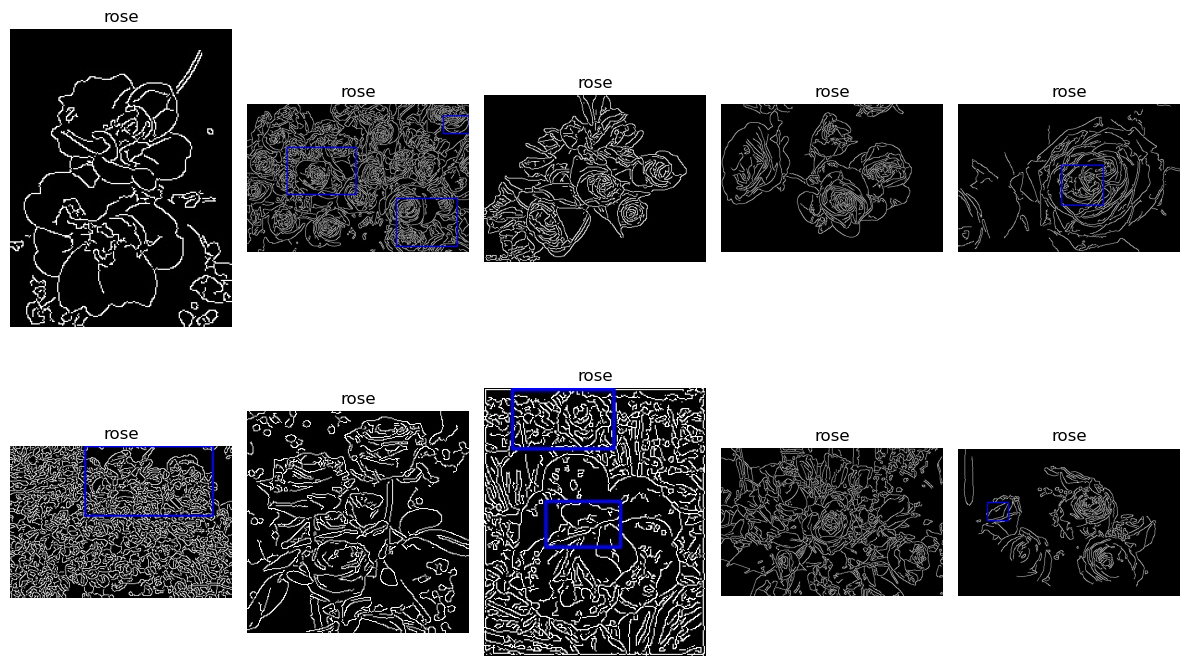

In [41]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the directory containing output images
output_directory = r"C:\Users\Saurav\Documents\ImageProcessingAssignment\detected_data\rose"  # Replace with your directory

# List all image files in the directory
image_files = [f for f in os.listdir(output_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Plot images
plt.figure(figsize=(12, 8))  # Set figure size
for i, img_file in enumerate(image_files[:10]):  # Limit to first 10 images for visualization
    img_path = os.path.join(output_directory, img_file)
    
    # Read image using cv2
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read {img_path}. Skipping.")
        continue
    
    # Convert BGR to RGB for displaying with matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Add subplot
    plt.subplot(2, 5, i + 1)  # Create a grid with 2 rows and 5 columns
    plt.imshow(image)
    plt.title("rose")  # Use filename as title
    plt.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


# ***Model training and classification***

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [58]:
# Paths and Configurations
DATASET_PATH = r"C:\Users\Saurav\Documents\ImageProcessingAssignment\images"
CLASSES = ['bougainvillea', 'daisy', 'frangipani', 'hibiscus', 'rose', 'sunflower', 'zinnia']
IMAGE_SIZE = (224, 224)  # Adjusted to VGG16's input size

# Helper function to load images
def load_images(dataset_path, classes, image_size):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset
images, labels = load_images(DATASET_PATH, CLASSES, IMAGE_SIZE)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding for CNN
y_train_cnn = to_categorical(y_train, num_classes=len(CLASSES))
y_test_cnn = to_categorical(y_test, num_classes=len(CLASSES))

# Load VGG16 model without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_cnn, validation_data=(X_test, y_test_cnn), epochs=10, batch_size=32, verbose=1)

# Save the model to disk
model.save("vgg16_model.h5")
print("Model saved as 'vgg16_model.h5'.")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cnn, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict and print classification report
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_cnn, target_names=CLASSES))



NameError: name 'train_test_split' is not defined

# ***Prediction using VCC16 model*** 

In [62]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Paths and Configurations
DATASET_PATH = r"C:\Users\Saurav\Documents\ImageProcessingAssignment\images"
CLASSES = ['bougainvillea', 'daisy', 'frangipani', 'hibiscus', 'rose', 'sunflower', 'zinnia']
IMAGE_SIZE = (224, 224)  # VGG16's input size

# Helper function to load images
def load_images(dataset_path, classes, image_size):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            image = cv2.imread(img_path)
            if image is None:
                print(f"Skipping invalid image: {img_path}")
                continue
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset
images, labels = load_images(DATASET_PATH, CLASSES, IMAGE_SIZE)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding for CNN
y_train_cnn = to_categorical(y_train, num_classes=len(CLASSES))
y_test_cnn = to_categorical(y_test, num_classes=len(CLASSES))

# Load VGG16 model without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_cnn, validation_data=(X_test, y_test_cnn), epochs=10, batch_size=32, verbose=1)

# Save the model to disk
model.save("vgg16_model.h5")
print("Model saved as 'vgg16_model.h5'.")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cnn, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict and print classification report
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_cnn, target_names=CLASSES))


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2208 - loss: 4.0896 - val_accuracy: 0.6031 - val_loss: 1.4185
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7767 - loss: 0.8907 - val_accuracy: 0.7863 - val_loss: 0.8524
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9410 - loss: 0.2982 - val_accuracy: 0.8092 - val_loss: 0.6593
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9817 - loss: 0.1721 - val_accuracy: 0.8702 - val_loss: 0.5691
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9965 - loss: 0.0802 - val_accuracy: 0.8626 - val_loss: 0.5200
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 1.0000 - loss: 0.0497 - val_accuracy: 0.8779 - val_loss: 0.4982
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 1.0000 - loss: 0.0324 - val_accuracy: 0.8702 - val_loss: 0.4866
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.8702 - val_loss:

Model saved as 'vgg16_model.h5'.
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9015 - loss: 0.4470
Test Accuracy: 0.89
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
               precision    recall  f1-score   support

bougainvillea       0.91      0.67      0.77        15
        daisy       1.00      0.96      0.98        25
   frangipani       0.86      1.00      0.92        18
     hibiscus       0.96      0.92      0.94        26
         rose       1.00      0.81      0.90        16
    sunflower       0.73      1.00      0.84         8
       zinnia       0.73      0.83      0.78        23

     accuracy                           0.89       131
    macro avg       0.88      0.88      0.88       131
 weighted avg       0.90      0.89      0.89       131



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


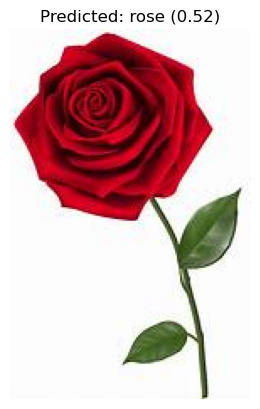

In [76]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("vgg16_model.h5")

# Function to preprocess and classify a single image
def classify_images(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    resized_image = cv2.resize(image, IMAGE_SIZE)
    normalized_image = resized_image / 255.0
    input_image = np.expand_dims(normalized_image, axis=0)  # Add batch dimension

    # Perform prediction
    predictions = model.predict(input_image)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]
    class_name = CLASSES[predicted_class]

    # Display the image with the prediction
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {class_name} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage
classify_images(r"C:\Users\Saurav\Documents\ImageProcessingAssignment\upload\rose2.jpg")


# ***Normal CNN MOdel Creation***

In [64]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7)
])

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,543 (15.22 MB)

 Trainable params: 3,989,543 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# ***Model Training***

In [32]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.1662 - loss: 2.1656 - val_accuracy: 0.2692 - val_loss: 1.8110
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3688 - loss: 1.6775 - val_accuracy: 0.3615 - val_loss: 1.5011
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5116 - loss: 1.2915 - val_accuracy: 0.4769 - val_loss: 1.2995
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5264 - loss: 1.1962 - val_accuracy: 0.4923 - val_loss: 1.2629
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5985 - loss: 1.0571 - val_accuracy: 0.5923 - val_loss: 1.1971
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6017 - loss: 1.0118 - val_accuracy: 0.5769 - val_loss: 1.2493
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6530 - loss: 0.9234 - val_accuracy: 0.6462 - val_loss: 1.1283
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6665 - loss: 0.8478 - val_accuracy: 0.6077 - 

# ***Classification***

In [34]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [36]:
model.save('Flower_Recog_Model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


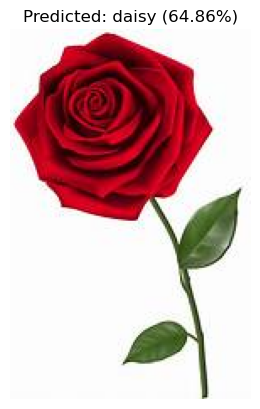

The image belongs to 'daisy' with a confidence of 64.86%.


In [85]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('Flower_Recog_Model.keras')

# Define flower names (ensure these match your dataset classes)
flower_names = ['bougainvillea', 'daisy', 'frangipani', 'hibiscus', 'rose', 'sunflower', 'zinnia']

# Function to classify and display an image
def classify_images(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return
    # Resize the image to the required size (180x180)
    resized_image = cv2.resize(image, (180, 180))
    # Normalize the image
    normalized_image = resized_image / 255.0
    # Expand dimensions to make it batch-compatible
    input_image = np.expand_dims(normalized_image, axis=0)

    # Predict the class probabilities
    predictions = model.predict(input_image)
    probabilities = tf.nn.softmax(predictions[0])
    predicted_class_index = np.argmax(probabilities)
    confidence = probabilities[predicted_class_index].numpy()
    class_name = flower_names[predicted_class_index]

    # Display the image with prediction
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {class_name} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Return the textual outcome
    return f"The image belongs to '{class_name}' with a confidence of {confidence * 100:.2f}%."

# Example usage
outcome = classify_images(r"C:\Users\Saurav\Documents\ImageProcessingAssignment\upload\rose2.jpg")
print(outcome)
